# Entrenamiento de una red neuronal multicapas
Implementación en Python de una red neuronal multicapas utilizando como función de activación la función sigmoide y como función de error la función de mínimos cuadrados. Para el entrenamiento se utilizará el conjunto de datos MNIST y el método de retropropagación.

## Librerías

In [2]:
# Importamos librerías.
import matplotlib.pyplot as plt              # Librería para graficación de datos
import pandas as pd                          # Librería para manejo de datos
import torch                                 # Pytorch
%matplotlib inline
# Función mágica que nos permite almacenar los gráficos en el notebook

In [3]:
import time                                 # Librería de python para obtener el tiempo de la maquina
import numpy as np
from torchvision import datasets            # Cargamos los conjuntos de datos disponibles de la librería
from torchvision import transforms          # Cargamos los transformadores de imágenes
from torch.utils.data import DataLoader
import torch.nn.functional as F             # Librería para cargar funciones de activación

## Configuraciones iniciales y conjunto de datos

In [4]:
# CONFIGURACIONES

SEED = 1 # Semilla para generación aleatoria
TAMAÑO_LOTE = 100 # Batch
NUM_EPOCAS = 5  # Epoch !!!!!!!  Aumentar el número de épocas puede incrementar considerablemente el tiempo de ejecución del programa.
DISPOSITIVO = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

La variable ```SEED``` será utilizada para generar un valor semialeatorio.

La variable ```TAMAÑO_LOTE``` se encargará de dividir el conjunto de datos en grupos de 100, en inglés se le conoce como **Batch**.

La variable ```NUM_EPOCAS``` se encargará de definir la cantidad de iteraciones que haremos al entrenamiento de la red neuronal, en inglés se le conoce como **Epoch**.

Por último la función ```torch.device``` se encarga de verificar sí estamos utilizando la GPU o la CPU del dispositivo.



In [5]:
# Conjunto de datos MNIST

datos_entrenamiento = datasets.MNIST(root = 'data',
                                     train = True,
                                     transform = transforms.ToTensor(),
                                     download = True)

datos_prueba = datasets.MNIST(root = 'data',
                              train = False,
                              transform = transforms.ToTensor())

cargador_entrenamiento = DataLoader(dataset = datos_entrenamiento,
                                    batch_size = TAMAÑO_LOTE,
                                    shuffle = True)

cargador_prueba = DataLoader(dataset = datos_prueba,
                             batch_size = TAMAÑO_LOTE,
                             shuffle = False)

# Imprimimos los conjuntos de datos
for imagenes, etiquetas in cargador_entrenamiento:
  print('Dimensiones del lote de imágenes: ', imagenes.shape)
  print('Dimensiones de las etiquetas de las imágenes: ', etiquetas.shape)
  break

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16215283.50it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 496091.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4436130.14it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4226875.70it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dimensiones del lote de imágenes:  torch.Size([100, 1, 28, 28])
Dimensiones de las etiquetas de las imágenes:  torch.Size([100])


Cargamos los datos que utilizaremos para entrenar la red neuronal a la variable ```datos_entrenamiento``` y los datos que utilizaremos para probar la red neuronal a la variable ```datos_prueba```. La variable ```cargador_entrenamiento``` se encarga de separar los datos de entrenamiento en lotes de tamaño ```TAMAÑO_LOTE```, del mismo modo la variable ```cargador_prueba``` separa los datos de ```datos_prueba```.

Por último imprimimos las dimensiones de las imágenes y las etiquetas del conjunto de entrenamiento. ```torch.Size([100, 1, 28, 28])``` nos indica las dimensiones de cada una de las imágenes en el conjunto de datos. 100 se refiere al tamaño del lote, 1 se refiere al color de la imágen (las imágenes son de color blanco y negro) y los dos últimos componentes indican el ancho y el alto de la imagen en pixeles. ```torch.Size([100])``` indica que hay 100 etiquetas distintas, puesto que cada imagen en el lote tiene su propia etiqueta (0-9) entonces cada una de las componentes de este vector será un número del 0 al 9.

Para mayor comprensión de las funciones [```datasets.MNIST()```](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), [```transforms.ToTensor()```](https://pytorch.org/vision/0.11/transforms.html) y [```DataLoader()```](https://pytorch.org/docs/stable/data.html)  se pueden revisar sus documentaciones.



tensor(2)


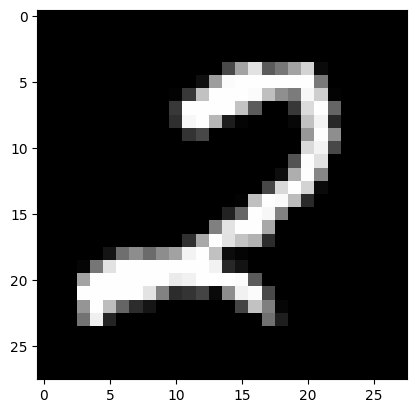

In [6]:
# Ejemplo
# Imprimimos la etiqueta de un número del conjunto de datos
print(etiquetas[0])
plt.imshow(imagenes[0].reshape(28,28), cmap="gray")

In [7]:
def to_onehot(y, num_clases):
  y_onehot = torch.FloatTensor(y.size(0), num_clases)
  y_onehot.zero_()
  tmp = y.view(-1, 1).long().to(torch.device('cpu'))
  y_onehot.scatter_(1, tmp, 1).float()
  return y_onehot

La función ```to_onehot``` crea un tensor de tamaño ```y.size(0)```×```num_clases```, luego llena este tensor de zeros con la función ```.zero_()```. El objetivo de esta función es generar un tensor que sea igual a los grupos de bits [one-hot](https://es.wikipedia.org/wiki/One-hot), para ello utilizamos la variable ```tmp``` y la última linea de código.



## Modelo

In [8]:
class MRNSigmoideMSE(torch.nn.Module):
  def __init__(self, num_caracteristicas, num_ocultas, num_clases):
    super(MRNSigmoideMSE, self).__init__()

    self.num_clases = num_clases

    # Primera capa oculta
    self.lineal_1 = torch.nn.Linear(num_caracteristicas, num_ocultas) # Asignamos a lineal_1 como una red neuronal lineal que tiene como entrada num_caracteristicas y salida num_ocultas
    self.lineal_1.weight.detach().normal_(0.0, 0.1)                   # Inicializamos los pesos de la red neuronal con una normalización con media 0.0 y desviación estandar 0.1
    self.lineal_1.bias.detach().zero_()

    # Capa de salida
    self.lineal_salida = torch.nn.Linear(num_ocultas, num_clases)   # Asignamos a lineal_salida como una red neuronal lineal que tiene como entrada num_ocultas y salida num_clases
    self.lineal_salida.weight.detach().normal_(0.0, 0.1)            # Inicializamos los pesos de la red neuronal con una normalización con media 0.0 y desviación estandar 0.1
    self.lineal_salida.bias.detach().zero_()                        # Inicializamos las bias de la red neuronal en ceros.


  # Definimos la propagación hacia delante
  def forward(self, x):
    salida = self.lineal_1(x)         # La información pasa a través de la capa oculta lineal_1
    salida = torch.sigmoid(salida)    # Se aplica la función sigmoide
    logits = self.lineal_salida(salida)   # La información pasa a la capa de salida
    probas = torch.sigmoid(logits)        # Se aplica la función sigmoide una última vez
    return logits, probas



Construimos una clase en python que va a ser nuestro modelo. ```MRNSigmoideMSE``` se refiere a una red neuronal multicapas que utiliza la función de activación sigmoide y además utiliza como función de error el promedio de mínimos cuadrados.

El objetivo de inicializar los pesos con media 0.0 y desviación estandar 0.1 es para un más fácil manejo de los datos y los cálculos.


 Para aquellos interesados en profundizar en las funciones de Pytorch pueden leer la [documentación de la librería](https://pytorch.org/docs/stable/index.html).

In [9]:
# Inicialización del modelo
torch.manual_seed(SEED)
modelo = MRNSigmoideMSE(num_caracteristicas = 28*28, # tamaño de las imágenes en pixeles
                        num_ocultas = 100,           # Capa oculta con 100 neuronas
                        num_clases = 10)             # numero de etiquetas (0-9) para identificar los números

modelo = modelo.to(DISPOSITIVO)

optimizador = torch.optim.SGD(modelo.parameters(), lr = 0.1) # lr: learning rate o velocidad de aprendizaje

In [10]:
# Entrenamiento

# función de error mínimo cuadrado (Minimal Square Error)
def compute_mse(red, cargador_datos):
  actual_mse, num_ejemplos = torch.zeros(modelo.num_clases).float(), 0
  with torch.no_grad():
    for caracteristicas, objetivos in cargador_datos:
      caracteristicas = caracteristicas.view(-1, 28*28).to(DISPOSITIVO) # Convertimos las imágenes en un tensor de tamaño 1x784
      logits, probas = red.forward(caracteristicas)                     # Aplicamos propagación hacia adelante
      probas = probas.to(torch.device('cpu'))
      y_onehot = to_onehot(objetivos, modelo.num_clases)                # Aplicamos función to_onehot
      perdida = torch.sum((y_onehot - probas)**2, dim=0)                # Calculaos la función de error
      num_ejemplos += objetivos.size(0)
      actual_mse += perdida

    actual_mse = torch.mean(actual_mse/num_ejemplos, dim = 0)           # Calculamos el promedio
    return actual_mse

In [11]:
start_time = time.time()
coste_pequeñolote = []
coste_epoca = []
for epoca in range(NUM_EPOCAS):
  modelo.train()
  for lote_idx, (caracteristicas, objetivos) in enumerate(cargador_entrenamiento):

    caracteristicas = caracteristicas.view(-1, 28*28).to(DISPOSITIVO)

    # RETROPROPAGACIÓN
    logits,probas = modelo(caracteristicas)

    y_onehot = to_onehot(objetivos, modelo.num_clases).to(DISPOSITIVO)

    costo = F.mse_loss(y_onehot, probas)
    optimizador.zero_grad()

    costo.backward()
    coste_pequeñolote.append(costo)

    # se actualizan los parámetros del modelo

    optimizador.step()

    # Salida por consola

    if not lote_idx % 50:
      print('Epoca: %03d/%03d | lote %03d/%03d | Costo: %.4f'
            %(epoca+1,NUM_EPOCAS, lote_idx,len(cargador_entrenamiento), costo))

  costo = compute_mse(modelo, cargador_entrenamiento)
  coste_epoca.append(costo)
  print('Epoca: %03d/%03d Costo de entrenamiento: %.4f' %
        (epoca+1, NUM_EPOCAS, costo))
  print('Tiempo transcurrido: %.2f min' % ((time.time() - start_time)/60))

print('Tiempo de entrenamiento total: %.2f min' % ((time.time() - start_time)/60))





Epoca: 001/005 | lote 000/600 | Costo: 0.2551
Epoca: 001/005 | lote 050/600 | Costo: 0.1029
Epoca: 001/005 | lote 100/600 | Costo: 0.0935
Epoca: 001/005 | lote 150/600 | Costo: 0.0908
Epoca: 001/005 | lote 200/600 | Costo: 0.0897
Epoca: 001/005 | lote 250/600 | Costo: 0.0900
Epoca: 001/005 | lote 300/600 | Costo: 0.0896
Epoca: 001/005 | lote 350/600 | Costo: 0.0888
Epoca: 001/005 | lote 400/600 | Costo: 0.0892
Epoca: 001/005 | lote 450/600 | Costo: 0.0886
Epoca: 001/005 | lote 500/600 | Costo: 0.0887
Epoca: 001/005 | lote 550/600 | Costo: 0.0883
Epoca: 001/005 Costo de entrenamiento: 0.0881
Tiempo transcurrido: 0.36 min
Epoca: 002/005 | lote 000/600 | Costo: 0.0877
Epoca: 002/005 | lote 050/600 | Costo: 0.0875
Epoca: 002/005 | lote 100/600 | Costo: 0.0885
Epoca: 002/005 | lote 150/600 | Costo: 0.0875
Epoca: 002/005 | lote 200/600 | Costo: 0.0869
Epoca: 002/005 | lote 250/600 | Costo: 0.0871
Epoca: 002/005 | lote 300/600 | Costo: 0.0860
Epoca: 002/005 | lote 350/600 | Costo: 0.0866
Epoc

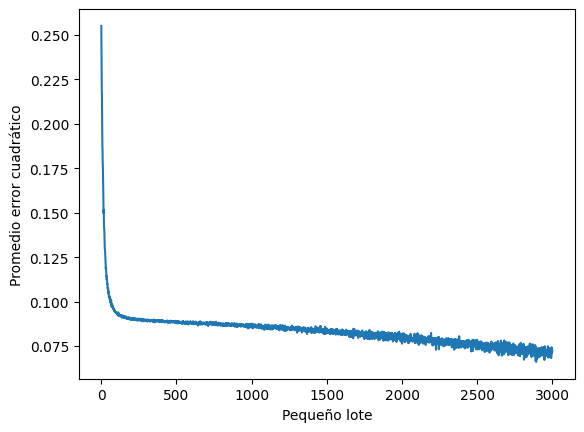

Text(0.5, 0, 'Epoca')

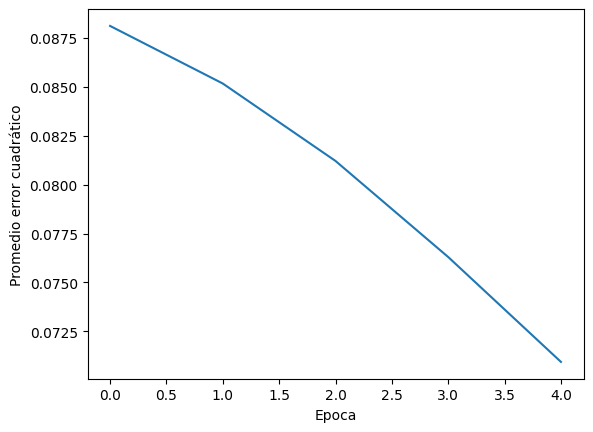

In [15]:
lote_final = [lf.item() for lf in coste_pequeñolote  ]
plt.plot(range(len(coste_pequeñolote)), lote_final)
plt.ylabel('Promedio error cuadrático')
plt.xlabel('Pequeño lote')
plt.show()

epoca_final = [ef.item() for ef in coste_epoca]
plt.plot(range(len(coste_epoca)), epoca_final)
plt.ylabel('Promedio error cuadrático')
plt.xlabel('Epoca')

In [18]:
def exactitud(red, cargador_datos):
  prediccion_correcta, num_ejemplos = 0, 0
  with torch.no_grad():
    for caracteristicas, objetivos in cargador_datos:
      caracteristicas = caracteristicas.view(-1, 28*28).to(DISPOSITIVO)
      objetivos = objetivos.to(DISPOSITIVO)
      a1, a2 = red.forward(caracteristicas)
      prediccion_etiquetas = torch.argmax(a2, 1)
      prediccion_correcta += torch.sum(prediccion_etiquetas == objetivos).item()
      num_ejemplos += objetivos.size(0)
    return prediccion_correcta / num_ejemplos * 100

print('Exactitud de entrenamiento: %.2f' % exactitud(modelo, cargador_entrenamiento))
print('Exactitud de prueba: %.2f' % exactitud(modelo, cargador_prueba))

Exactitud de entrenamiento: 58.59
Exactitud de prueba: 59.15


La exactitud del entrenamiento y la exactitud de las pruebas está fuertemente ligado a varios factores en la toma de decisión previa al entrenamiento entre ellos la elección de la cantidad de capas ocultas, la elección en la cantidad de neuronas, la elección en la cantidad de épocas y lotes de datos.